Licensed under the MIT License.

Copyright (c) 2025-2035. All rights reserved by Hanhan Wu.

Permission is hereby granted to view this code for evaluation purposes only.
You may not reuse, copy, modify, merge, publish, distribute, sublicense,
or exploit this code without Hanhan Wu's EXPLICIT written permission.


# AdalFlow on FIQA Data & Optimize Answer Generation

* Optimization
  * teacher generator for few-shot learning
  * backward_engine & optimizer for text_grad optimization
  * Added `self.configure_text_optimizer_helper()` to customize LLM used in the optimization
  * Added `few_shot_demos` to add examples in training, indeed improved the performance here
  * Added `regularization_fn` in `optimizer_config`

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import re
import dspy
import contextlib
import json
import matplotlib.pyplot as plt
from pprint import pprint
from datasets import load_dataset
from dataclasses import dataclass, field
from typing import Union, Dict, Callable, Any, Tuple

import adalflow as adal
from adalflow.datasets.hotpot_qa import HotPotQAData
from adalflow.components.model_client.openai_client import OpenAIClient
from adalflow.optim import TextOptimizer
from adalflow.eval.g_eval import GEvalLLMJudge, GEvalJudgeEvaluator, NLGTask

import warnings
warnings.filterwarnings('ignore')


model_str = "gpt-4.1-nano"
gpt4_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": model_str,
        "temperature": 0.7,
    },
}
model_kwargs = {
        "model": model_str,
        "temperature": 0.7,
    }

### Create Data Input

* Load fiqa data and convert to AdalFlow's HotPotQAData format
  * So far, this is the only data format I knew AdalFlow can process...😅
* About the Data Source: https://huggingface.co/datasets/explodinggradients/fiqa
  * Only 30 records

In [2]:
fiqa_eval = load_dataset("explodinggradients/fiqa", "ragas_eval")['baseline']

rag_lst = []
for record in fiqa_eval:
    rag_lst.append({
        'question': record['question'],
        'context': record['contexts'],
        'ground_truth': record['ground_truths'][0],
        'answer_before_prompt_opt': record['answer'].strip()
    })

rag_df = pd.DataFrame(rag_lst)
print(rag_df.shape)
rag_df.head()

(30, 4)


,question,context,ground_truth,answer_before_prompt_opt
0,How to deposit a cheque issued to an associate...,[Just have the associate sign the back and the...,Have the check reissued to the proper payee.Ju...,The best way to deposit a cheque issued to an ...
1,Can I send a money order from USPS as a business?,[Sure you can. You can fill in whatever you w...,Sure you can. You can fill in whatever you wa...,"Yes, you can send a money order from USPS as a..."
2,1 EIN doing business under multiple business n...,[You're confusing a lot of things here. Compan...,You're confusing a lot of things here. Company...,"Yes, it is possible to have one EIN doing busi..."
3,Applying for and receiving business credit,[Set up a meeting with the bank that handles y...,"""I'm afraid the great myth of limited liabilit...",Applying for and receiving business credit can...
4,401k Transfer After Business Closure,[The time horizon for your 401K/IRA is essenti...,You should probably consult an attorney. Howev...,If your employer has closed and you need to tr...


In [3]:
def fiqa_to_hotpotqa(record):
    return HotPotQAData(
        question=record['question'],
        gold_titles=record['ground_truths'][0],
        context=record['contexts'],
        answer=record['answer'].strip(),  # answer_before_prompt_opt
    )

fiqa_as_hotpotqa = [fiqa_to_hotpotqa(s) for s in fiqa_eval]
print(len(fiqa_as_hotpotqa))
fiqa_as_hotpotqa[0].to_dict()

30


{'question': 'How to deposit a cheque issued to an associate in my business into my business account?',
 'answer': 'The best way to deposit a cheque issued to an associate in your business into your business account is to open a business account with the bank. You will need a state-issued "dba" certificate from the county clerk\'s office as well as an Employer ID Number (EIN) issued by the IRS. Once you have opened the business account, you can have the associate sign the back of the cheque and deposit it into the business account.',
 'id': '5a8d8595-1b6b-4a62-9133-f4163247058d',
 'gold_titles': "Have the check reissued to the proper payee.Just have the associate sign the back and then deposit it.  It's called a third party cheque and is perfectly legal.  I wouldn't be surprised if it has a longer hold period and, as always, you don't get the money if the cheque doesn't clear. Now, you may have problems if it's a large amount or you're not very well known at the bank.  In that case you

### AdalFlow Optimization

* References
  * How to use AdalFlow's GEval and LLM-as-Judge: https://colab.research.google.com/github/SylphAI-Inc/AdalFlow/blob/main/notebooks/evaluation/adalflow_llm_eval.ipynb
  * Official evaluation page (I think their user guide is very confusing 😅): https://adalflow.sylph.ai/apis/eval/index.html

In [4]:
task_desc_str = r"""Answer questions with short factoid answers.
                    You will receive context(contain relevant facts).
                    Think step by step.
                """


prompt_template = """<START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
    Here are some examples:
    {{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
    Context: {{context}}
    Question: {{question}}
<END_OF_USER>
"""


trainset = fiqa_as_hotpotqa[0:10]
valset = fiqa_as_hotpotqa[10:20]
testset = fiqa_as_hotpotqa[20:]


def format_few_shot_demo(example):
    return f"Context: {example.context}\nQuestion: {example.question}\nAnswer: {example.answer}\n"

few_shot_examples = trainset[:3]  # Use first 3 as demos
few_shot_demos_str = "\n---\n".join([format_few_shot_demo(e) for e in few_shot_examples])
print(few_shot_demos_str)

Context: ['Just have the associate sign the back and then deposit it.  It\'s called a third party cheque and is perfectly legal.  I wouldn\'t be surprised if it has a longer hold period and, as always, you don\'t get the money if the cheque doesn\'t clear. Now, you may have problems if it\'s a large amount or you\'re not very well known at the bank.  In that case you can have the associate go to the bank and endorse it in front of the teller with some ID.  You don\'t even technically have to be there.  Anybody can deposit money to your account if they have the account number. He could also just deposit it in his account and write a cheque to the business."I have checked with Bank of America, and they say the ONLY way to cash (or deposit, or otherwise get access to the funds represented by a check made out to my business) is to open a business account. They tell me this is a Federal regulation, and every bank will say the same thing.  To do this, I need a state-issued ""dba"" certificat

In [5]:
@dataclass
class AnswerData(adal.DataClass):
    reasoning: str = field(
        metadata={"desc": "The reasoning to produce the answer"},
    )
    answer: str = field(
        metadata={"desc": "The answer you produced"},
    )

    __output_fields__ = ["reasoning", "answer"]


class RAG_AnswerGeneration(adal.Component):
    def __init__(self, model_client=None, model_kwargs=None):
        super().__init__()

        self.llm_parser = adal.DataClassParser(
            data_class=AnswerData, return_data_class=True, format_type="json"
        )
        self.llm = adal.Generator(
            model_client=model_client,
            model_kwargs=model_kwargs,
            prompt_kwargs={
                "task_desc_str": adal.Parameter(
                    data=task_desc_str,
                    role_desc="""Task description for the language model,\
                            used with the following template: \
                                {{task_desc_str}} \
                                {{output_format_str}}\
                            <START_OF_USER>
                                Context: {{context}}
                                Question: {{question}}
                            <END_OF_USER>""",
                    param_type=adal.ParameterType.PROMPT,
                    requires_opt=True,
                    instruction_to_backward_engine="""You need find the best way
                            (where does the right answer come from the context) 
                            to extract the RIGHT answer from the context.""",
                    instruction_to_optimizer="""
                        Write ONLY general instructions for answering questions. 
                        Do NOT include any specific answers, facts, or content from the dataset or any query. 
                        Do NOT copy or paraphrase any ground-truth answer. 
                        Your output must be a reusable prompt template, not a response to a specific question.
                    """,
                ),
                "output_format_str": self.llm_parser.get_output_format_str(),
            },
            template=prompt_template,
            output_processors=self.llm_parser,
            use_cache=True,
        )

    def bicall(
        self, 
        question: str, 
        retrieved_context: str,
        id: str = None,
        few_shot_demos: str = None
    ) -> Union[adal.GeneratorOutput, adal.Parameter]:
        """
            This function is used to call the model for both training and eval mode.
        """
        prompt_kwargs = {
            "context": retrieved_context,
            "question": question,
        }
        if few_shot_demos is not None:
            prompt_kwargs["few_shot_demos"] = few_shot_demos
        output = self.llm(prompt_kwargs=prompt_kwargs, id=id)
        return output

In [6]:
# test above RAG_AnswerGeneration logic
random_test_data = fiqa_as_hotpotqa[0].to_dict()

rag = RAG_AnswerGeneration(**gpt4_model)
output = rag.bicall(
    question=random_test_data['question'],
    retrieved_context=random_test_data['context'],
    few_shot_demos=few_shot_demos_str
)
print(output)
pprint(output.data)

GeneratorOutput(id=None, data=AnswerData(reasoning='The context explains that a cheque issued to an associate can be deposited into a business account if the associate signs the back of the cheque and deposits it. It also mentions that having an account in the business name simplifies this process.', answer='Have the associate sign the back of the cheque and deposit it into your business account.'), error=None, usage=CompletionUsage(completion_tokens=79, prompt_tokens=2598, total_tokens=2677), raw_response='```json\n{\n    "reasoning": "The context explains that a cheque issued to an associate can be deposited into a business account if the associate signs the back of the cheque and deposits it. It also mentions that having an account in the business name simplifies this process.",\n    "answer": "Have the associate sign the back of the cheque and deposit it into your business account."\n}\n```', metadata=None)
AnswerData(reasoning='The context explains that a cheque issued to an '
   

In [7]:
class HotPotQAAdal(adal.AdalComponent):
    def __init__(
        self,
        backward_engine_model_config: Dict | None = None,
        teacher_model_config: Dict | None = None,
        text_optimizer_model_config: Dict | None = None,
        task: adal.Component | None = None,  # initialized task
    ):
        g_eval = GEvalLLMJudge(default_task=NLGTask.SUMMARIZATION,
                                model_kwargs=model_kwargs)
        g_evaluator = GEvalJudgeEvaluator(llm_judge=g_eval)
        def extract_overall(**kwargs):
            if 'input_str'  in kwargs:
                match = re.search(r"Reference Answer:(.*)Predicted Answer:(.*)", kwargs['input_str'], re.DOTALL)
                if match:
                    reference = match.group(1).strip()
                    predicted = match.group(2).strip()
            else:
                predicted = kwargs.get("y")
                reference = kwargs.get("y_gt")

            input_str = f"Reference Answer: {reference}\nPredicted Answer: {predicted}"
            return g_evaluator.compute_single_item(input_str)["overall"]

        eval_fn = extract_overall
        loss_eval_fn = extract_overall

        loss_fn = adal.EvalFnToTextLoss(
            eval_fn=loss_eval_fn,
            eval_fn_desc="GEval score",
        )
        super().__init__(
            task=task,
            eval_fn=eval_fn,
            loss_eval_fn=loss_eval_fn,
            loss_fn=loss_fn,
            backward_engine_model_config=backward_engine_model_config,
            teacher_model_config=teacher_model_config,
            text_optimizer_model_config=text_optimizer_model_config,
        )
        self.configure_text_optimizer_helper(
            model_client=OpenAIClient(),
            model_kwargs={"temperature": 0.3}
        )

    def prepare_task(self, sample: HotPotQAData) -> Tuple[Callable[..., Any], Dict]:
        task_kwargs = {
            "question": sample.question,
            "retrieved_context": sample.context,
            "id": getattr(sample, "id", None),
            "few_shot_demos": few_shot_demos_str,
        }
        if self.task.training:
            return self.task.forward, task_kwargs
        else:
            return self.task.call, task_kwargs

    def prepare_eval(self, sample: HotPotQAData, y_pred: adal.GeneratorOutput):
        y_label = ""
        if y_pred and y_pred.data and y_pred.data.answer:
            y_label = y_pred.data.answer

        input_str = (
            f"Reference Answer: {sample.gold_titles}\n"
            f"Predicted Answer: {y_label}"
        )

        return self.eval_fn, {'input_str': input_str}


    def prepare_loss_eval(self, sample: Any, y_pred: Any, *args, **kwargs):
        y_label = ""
        if y_pred and y_pred.data and y_pred.data.answer:
            y_label = y_pred.data.answer

        input_str = (
            f"Reference Answer: {sample.gold_titles}\n"
            f"Predicted Answer: {y_label}"
        )

        return self.loss_eval_fn, {'input_str': input_str}


    def prepare_loss(self, sample: HotPotQAData, pred: adal.Parameter):
        y_gt = adal.Parameter(
            name="y_gt",
            data=sample.gold_titles,
            eval_input=sample.gold_titles,
            requires_opt=False,
        )
        context_param = adal.Parameter(
            name="context",
            data=sample.context,
            eval_input=sample.context,  # you could also stringify it if needed
            requires_opt=False,
        )

        pred.eval_input = (
            pred.data.data.answer
            if pred.data and pred.data.data and pred.data.data.answer
            else ""
        )
        return self.loss_fn, {
            "kwargs": {"y": pred, "y_gt": y_gt,
                        "context": context_param},
            "input": {"question": sample.question,
                       "retrieved_context": sample.context},
            "gt": sample.gold_titles,
            "id": sample.id,
        }

<b>Evaluation Only</b>

In [8]:
def train_diagnose(model_client, model_kwargs):
    task = RAG_AnswerGeneration(
        model_client=model_client,
        model_kwargs=model_kwargs
    )

    adal_component = HotPotQAAdal(task=task)
    trainer = adal.Trainer(adaltask=adal_component)
    trainer.diagnose(dataset=testset, split="train")


train_diagnose(**gpt4_model)

Generator llm is already registered with jsonl file at C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\VallinaRAGAdal\diagnose_train\llm_call.jsonl


2025-07-20 22:43:22 - [adal.py:852:configure_text_optimizer_helper] - Text optimizer configured for 1 parameters. names: [('llm.task_desc_str', 'Answer questions with short factoid answers.\n                    You will receive context(contain relevant facts).\n                    Think step by step.\n                ')]
2025-07-20 22:43:22 - [trainer.py:227:diagnose] - Checkpoint path: C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal


Loading Data: 100%|██████████| 10/10 [00:00<00:00, 861.01it/s]
Predicting: step(0): 0.69 across 10 samples, Max potential: 0.69: 100%|██████████| 10/10 [00:00<00:00, 55.30it/s]  
Error loading jsonl file C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\VallinaRAGAdal\diagnose_train\llm_call.jsonl: line contains invalid json: Trailing data (line 46)


Log file C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\VallinaRAGAdal\diagnose_train\llm_call.jsonl is empty. This llm is not called at all.

================== DIAGNOSE REPORT ==================

✔ Split: train
✔ Overall accuracy score: 0.69
✔ Log paths:
  - Log 1: C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\VallinaRAGAdal\diagnose_train\llm_call.jsonl

✔ Diagnose report completed successfully!




<b>Training</b>

In [9]:
def regularization_fn(prompt: str, sample: HotPotQAData) -> float:
    # Penalize if ground-truth answer appears in the prompt
    if sample.answer.strip() in prompt or sample.question.strip() in prompt:
        return 1.0  # High penalty
    return 0.0     # No penalty

optimizer_config = {
    "regularization_fn": regularization_fn,
}

def train(
    task_model_cliet,
    task_model_kwargs,
    optimizer_model_config,
    backward_engine_model_config,
    train_batch_size=4,  # larger batch size is not that effective, probably because of llm's lost in the middle
    raw_shots: int = 0,
    bootstrap_shots: int = 4,
    max_steps=1,
    num_workers=4,
    strategy="constrained",
    optimization_order="sequential",
    debug=False,
    resume_from_ckpt=None,
    exclude_input_fields_from_bootstrap_demos=True,
    seed=10,
    max_proposals_per_step: int = 5,
    disable_backward_gradients: bool = False,
    disable_backward: bool = False,
):
    task = RAG_AnswerGeneration(
        model_client=task_model_cliet,
        model_kwargs=task_model_kwargs
    )

    adal_component = HotPotQAAdal(
        task=task,
        text_optimizer_model_config=optimizer_model_config,
        backward_engine_model_config=backward_engine_model_config,
    )

    trainer = adal.Trainer(
        train_batch_size=train_batch_size,
        optimizer_config = optimizer_config,
        adaltask=adal_component,
        strategy=strategy,
        max_steps=max_steps,
        num_workers=num_workers,
        raw_shots=raw_shots,
        bootstrap_shots=bootstrap_shots,
        debug=debug,
        weighted_sampling=False,
        optimization_order=optimization_order,
        exclude_input_fields_from_bootstrap_demos=exclude_input_fields_from_bootstrap_demos,
        max_proposals_per_step=max_proposals_per_step,
        text_optimizers_config_kwargs={"max_past_history": 5},
        disable_backward_gradients=disable_backward_gradients,
        disable_backward=disable_backward,
    )
    trainer.set_random_seed(seed)
    print(trainer)

    ckpt, _ = trainer.fit(
        train_dataset=trainset,
        val_dataset=valset,
        test_dataset=testset,
        resume_from_ckpt=resume_from_ckpt,
    )
    return ckpt

In [10]:
train(
    task_model_cliet=gpt4_model["model_client"],
    task_model_kwargs=gpt4_model["model_kwargs"],
    optimizer_model_config=gpt4_model,
    backward_engine_model_config=gpt4_model,
    max_steps=12,
)

2025-07-20 22:43:31 - [adal.py:852:configure_text_optimizer_helper] - Text optimizer configured for 1 parameters. names: [('llm.task_desc_str', 'Answer questions with short factoid answers.\n                    You will receive context(contain relevant facts).\n                    Think step by step.\n                ')]
Trainer(
  (adaltask): HotPotQAAdal(
    eval_fn: extract_overall, backward_engine: None, backward_engine_model_config: {'model_client': OpenAIClient(), 'model_kwargs': {'model': 'gpt-4.1-nano', 'temperature': 0.7}}, teacher_model_config: None, text_optimizer_model_config: {'model_client': OpenAIClient(), 'model_kwargs': {'model': 'gpt-4.1-nano', 'temperature': 0.7}}
    (task): RAG_AnswerGeneration(
      (llm_parser): DataClassParser(
        data_class=AnswerData, format_type=json,            return_data_class=True, input_fields=[],            output_fields=['reasoning', 'answer']
        (_output_processor): JsonParser()
        (output_format_prompt): template: Yo

Loading Data: 100%|██████████| 10/10 [00:00<00:00, 903.42it/s]
Predicting: step(0): 0.7083 across 10 samples, Max potential: 0.7083: 100%|██████████| 10/10 [00:00<00:00, 93.64it/s]
Loading Data: 100%|██████████| 10/10 [00:00<00:00, 114.33it/s]
Predicting: step(0): 0.69 across 10 samples, Max potential: 0.69: 100%|██████████| 10/10 [00:00<00:00, 113.09it/s]  


Initial validation score: 0.7083333333333333
Initial test score: 0.6900000000000001
2025-07-20 22:43:31 - [trainer.py:2343:_fit_text_grad_constraint] - Fitting using Textual Gradient Descent with constraints
_fit_text_grad_constraint save to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


Training: 100%|██████████| 4/4 [00:00<00:00, 384.73it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 231.96it/s]


Moving batch eval: EvaluationResult(avg_score=0.5916666666666667, per_item_scores=[0.5666666666666667, 0.41666666666666663, 0.7166666666666667, 0.6666666666666667], additional_info=None)
2025-07-20 22:43:32 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.5916666666666667
Moving batch correct size: 3
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.5499999999999999
2025-07-20 22:43:32 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.5499999999999999,0.5499999999999999
Subset loss backward...
Subset loss backward time: 13.30326771736145
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-20 22:43:47 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.0606839656829834
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Have the cheque reissued to the proper payee, such as the business name, and then deposit it into your business account.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 172.56it/s]
Predicting: step(1): 0.6167 across 3 samples, Max potential: 0.6167: 100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


2025-07-20 22:43:55 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6166666666666667 > 0.5499999999999999




Loading Data:   0%|          | 0/10 [00:00<?, ?it/s]

Loading Data: 100%|██████████| 10/10 [00:00<00:00, 72.26it/s]
Predicting: step(1): 0.7967 across 10 samples, Max potential: 0.7967: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Optimizer step: 0.7966666666666666 > 0.7083333333333333


Proposing:   0%|          | 0/5 [00:27<?, ?it/s]


Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 43.44it/s]


Moving batch eval: EvaluationResult(avg_score=0.6166666666666667, per_item_scores=[0.7166666666666668, 0.4666666666666667, 0.7666666666666666, 0.5166666666666667], additional_info=None)
2025-07-20 22:44:16 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6166666666666667
Moving batch correct size: 3
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.5666666666666668
2025-07-20 22:44:16 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.5666666666666668,0.5666666666666668
Subset loss backward...
Subset loss backward time: 6.5201005935668945
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-20 22:44:24 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4792702198028564
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Yes, an entrepreneur can hire a self-employed business owner, provided the contractual relationship clearly defines the individual as self-employed and not an employee, in accordance with legal and tax regulations.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 103.95it/s]
Predicting: step(2): 0.5833 across 3 samples, Max potential: 0.5833: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


2025-07-20 22:44:30 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.5833333333333334 > 0.5666666666666668




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 803.83it/s]
Predicting: step(2): 0.7452 across 7 samples, Max potential: 0.8217:  70%|███████   | 7/10 [00:15<00:06,  2.15s/it]


Optimizer revert: 0.7291666666666667 <= 0.7966666666666666



Proposing:  20%|██        | 1/5 [00:22<01:30, 22.69s/it]

Proposal: 2
2025-07-20 22:44:47 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.6949634552001953
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Yes, an entrepreneur can hire a self-employed business owner, provided the contractual relationship clearly defines independent contractor status and complies with relevant legal and tax regulations.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 334.70it/s]
Predicting: step(2): 0.5333 across 3 samples, Max potential: 0.5333: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


2025-07-20 22:44:53 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5333333333333333 <= 0.5666666666666668



Proposing:  40%|████      | 2/5 [00:29<00:40, 13.60s/it]

Proposal: 3
2025-07-20 22:44:54 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4177320003509521
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The primary goal of deductible amounts for small businesses is to lower taxable income and support legitimate business and health expenses, thereby reducing overall tax liability and aiding expense management.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 135.29it/s]
Predicting: step(2): 0.6167 across 3 samples, Max potential: 0.6167: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


2025-07-20 22:45:00 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6166666666666667 > 0.5666666666666668




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 566.38it/s]
Predicting: step(2): 0.7479 across 8 samples, Max potential: 0.7983:  80%|████████  | 8/10 [00:14<00:03,  1.82s/it]


Optimizer revert: 0.7592592592592593 <= 0.7966666666666666



Proposing:  60%|██████    | 3/5 [00:51<00:34, 17.22s/it]

Proposal: 4
2025-07-20 22:45:16 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.6906616687774658
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Yes, an entrepreneur can hire a self-employed business owner, provided the contractual arrangements and circumstances support a self-employment relationship rather than employment.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 353.65it/s]
Predicting: step(2): 0.5833 across 3 samples, Max potential: 0.5833: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


2025-07-20 22:45:21 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.5833333333333334 > 0.5666666666666668




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 643.07it/s]
Predicting: step(2): 0.7741 across 9 samples, Max potential: 0.7967:  90%|█████████ | 9/10 [00:17<00:01,  1.90s/it]


Optimizer revert: 0.7816666666666666 <= 0.7966666666666666



Proposing:  80%|████████  | 4/5 [01:14<00:19, 19.68s/it]

Proposal: 5
2025-07-20 22:45:40 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.769005537033081
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Yes, an entrepreneur can hire a self-employed business owner, provided the contractual arrangements and circumstances support a self-employment relationship rather than employment.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 186.33it/s]
Predicting: step(2): 0.5833 across 3 samples, Max potential: 0.5833: 100%|██████████| 3/3 [00:00<00:00, 48.73it/s]


2025-07-20 22:45:40 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.5833333333333334 > 0.5666666666666668




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 609.74it/s]
Predicting: step(2): 0.7741 across 9 samples, Max potential: 0.7967:  90%|█████████ | 9/10 [00:00<00:00, 38.01it/s]


Optimizer revert: 0.7816666666666666 <= 0.7966666666666666



Proposing: 100%|██████████| 5/5 [01:17<00:00, 15.51s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json
Done with proposals


Training: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]

Evaluating: 100%|██████████| 6/6 [00:00<00:00, 69.82it/s]


Moving batch eval: EvaluationResult(avg_score=0.6666666666666666, per_item_scores=[0.7166666666666668, 0.4666666666666667, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666], additional_info=None)
2025-07-20 22:45:45 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6666666666666666
Moving batch correct size: 5
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.6666666666666666
2025-07-20 22:45:46 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6666666666666666,0.6666666666666666
Subset loss backward...
Subset loss backward time: 7.28583025932312
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-20 22:45:56 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.7175188064575195
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Filing personal taxes with 1099 income involves reporting income directly on your individual return and paying self-employment taxes quarterly, but it offers limited legal protections and fewer opportunities for deducting business expenses. Operating as an LLC or S-corp means your business income is reported on a separate corporate return (Form 1120S), which provides liability protection and allows you to pay yourself a salary, potentially reducing self-employment taxes. Additionally, these structures enable more comprehensive deduction of business expenses. The choice depends on your specific needs, expenses, and risk considerations, but generally, LLCs or S-corps offer significant legal protections and tax advantages over sole proprietorship or direct 1099 filing.'



Loading Data: 100%|██████████| 3/3 [00:00<00:00, 485.47it/s]
Predicting: step(3): 0.5333 across 3 samples, Max potential: 0.5333: 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


2025-07-20 22:46:02 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5333333333333333 <= 0.6666666666666666



Proposing:  20%|██        | 1/5 [00:08<00:35,  8.92s/it]

Proposal: 2
2025-07-20 22:46:05 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.9076669216156006
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Filing personal taxes with 1099 income involves reporting your income directly on your individual tax return and paying self-employment taxes quarterly, but it offers limited legal protections and fewer opportunities for deductions. Operating as an S-corp, on the other hand, means your business income is reported on a separate corporate tax return (Form 1120S), allowing you to pay yourself a salary, potentially reduce self-employment taxes, and benefit from liability protections and more substantial business expense deductions. The choice depends on your specific circumstances, but generally, forming an LLC or S-corp provides significant legal protections and tax advantages that are not available when simply filing as a sole proprietor or with 1099 income.', requires



Loading Data: 100%|██████████| 3/3 [00:00<00:00, 466.95it/s]
Predicting: step(3): 0.65 across 3 samples, Max potential: 0.65: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]    


2025-07-20 22:46:11 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6499999999999999 <= 0.6666666666666666



Proposing:  40%|████      | 2/5 [00:17<00:26,  8.92s/it]

Proposal: 3
2025-07-20 22:46:14 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.582848072052002
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Filing personal taxes with 1099 income involves reporting income directly on your individual return and paying self-employment taxes quarterly, with limited legal protections and fewer deductible expenses. Operating as an LLC or S-corp means your business income is reported on a separate corporate return (Form 1120S), allowing you to pay yourself a salary and potentially reduce self-employment taxes, while also providing liability protection and the ability to deduct business expenses more effectively. The decision depends on your specific situation, expenses, and risk considerations, but generally, an LLC or S-corp offers significant legal protections and tax advantages over sole proprietorship or simple 1099 reporting, making it a preferable choice for many business



Loading Data: 100%|██████████| 3/3 [00:00<00:00, 227.06it/s]
Predicting: step(3): 0.5833 across 3 samples, Max potential: 0.5833: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


2025-07-20 22:46:19 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5833333333333334 <= 0.6666666666666666



Proposing:  60%|██████    | 3/5 [00:25<00:16,  8.44s/it]

Proposal: 4
2025-07-20 22:46:24 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 4.755796432495117
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Filing personal taxes with 1099 income involves reporting income directly on your individual return and paying self-employment taxes quarterly, with limited legal protections and fewer deductible expenses. Operating as an S-corp means your business income is reported on a separate corporate return (Form 1120S), allowing you to pay yourself a salary, potentially reduce self-employment taxes, and benefit from liability protection and more deductible business expenses. The choice depends on your specific situation, expenses, and risk considerations, but generally, an LLC or S-corp offers advantages in legal protection and tax planning over sole proprietorship or 1099 filing alone.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 440.13it/s]
Predicting: step(3): 0.65 across 3 samples, Max potential: 0.65: 100%|██████████| 3/3 [00:06<00:00,  2.11s/it]    


2025-07-20 22:46:30 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.65 <= 0.6666666666666666



Proposing:  80%|████████  | 4/5 [00:37<00:09,  9.60s/it]

Proposal: 5
2025-07-20 22:46:33 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.288154125213623
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Filing personal taxes with 1099 income involves reporting the income on your individual tax return and paying self-employment taxes, which can be higher and less flexible. Operating as an S-corp means your business income is reported separately via Form 1120S, allowing you to pay yourself a salary and potentially reduce self-employment taxes, while also offering legal protections and the ability to deduct business expenses. The decision depends on your entity structure and financial goals, but generally, an S-corp provides better legal protection and tax planning opportunities compared to sole proprietorship or direct 1099 reporting.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 489.57it/s]
Predicting: step(3): 0.65 across 3 samples, Max potential: 0.65: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]    


2025-07-20 22:46:38 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.65 <= 0.6666666666666666



Proposing: 100%|██████████| 5/5 [00:44<00:00,  8.95s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json
Done with proposals


Epoch:  20%|██        | 1/5 [03:06<12:26, 186.59s/it]

Epoch: 1


Training: 100%|██████████| 4/4 [00:00<00:00, 185.26it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 181.79it/s]


Moving batch eval: EvaluationResult(avg_score=0.6266666666666667, per_item_scores=[0.7166666666666668, 0.4666666666666667, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7166666666666668, 0.4666666666666667, 0.6666666666666667, 0.41666666666666663], additional_info=None)
2025-07-20 22:46:38 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6266666666666667
Moving batch correct size: 7
Moving batch error size: 3
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.5666666666666667
2025-07-20 22:46:38 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.5666666666666667,0.5666666666666667
Subset loss backward...
Subset loss backward time: 9.199041366577148
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-20 22:46:50 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.9001762866973877
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data="Yes, it is possible to have one EIN operating under multiple business names by filing a 'Doing Business As' (DBA) registration with your local government. After filing, you should have the DBA verified with your bank, which may involve the bank calling the county seat to confirm the DBA registration. This process involves paying a processing fee for the DBA. Once verified, you can operate your business under multiple trade names using the same EIN, provided you keep proper records.", requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 512.66it/s]
Predicting: step(4): 0.5792 across 4 samples, Max potential: 0.5792: 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


2025-07-20 22:46:58 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.5791666666666666 > 0.5666666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1162.66it/s]
Predicting: step(4): 0.7521 across 8 samples, Max potential: 0.8017:  80%|████████  | 8/10 [00:15<00:03,  1.95s/it]


Optimizer revert: 0.7592592592592591 <= 0.7966666666666666



Proposing:  20%|██        | 1/5 [00:26<01:45, 26.30s/it]

Proposal: 2
2025-07-20 22:47:16 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.07586669921875
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data="Yes, it is possible to have one EIN doing business under multiple business names by filing a 'Doing Business As' (DBA) registration with your local government and having the bank verify the DBA. This process involves submitting the DBA form, which must be processed and recorded, and then using the same EIN for all the trade names. The verification ensures that your business operates legally under multiple trade names without needing separate EINs.", requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 468.61it/s]
Predicting: step(4): 0.6292 across 4 samples, Max potential: 0.6292: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


2025-07-20 22:47:24 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6291666666666667 > 0.5666666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1052.21it/s]
Predicting: step(4): 0.7714 across 7 samples, Max potential: 0.84:  70%|███████   | 7/10 [00:16<00:07,  2.36s/it]  


Optimizer revert: 0.7395833333333333 <= 0.7966666666666666



Proposing:  40%|████      | 2/5 [00:52<01:19, 26.44s/it]

Proposal: 3
2025-07-20 22:47:43 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.0690150260925293
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data="Yes, it is possible to have one EIN doing business under multiple business names by filing a 'Doing Business As' (DBA) registration with your local government, having the bank call the county seat to verify the DBA, and ensuring the DBA form is properly processed and recorded. This allows a single EIN to be associated with multiple trade names, provided the legal and procedural steps are followed.", requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 478.76it/s]
Predicting: step(4): 0.6167 across 4 samples, Max potential: 0.6167: 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


2025-07-20 22:47:51 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6166666666666667 > 0.5666666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 843.36it/s]
Predicting: step(4): 0.7143 across 7 samples, Max potential: 0.8:  70%|███████   | 7/10 [00:15<00:06,  2.21s/it]   


Optimizer revert: 0.7083333333333333 <= 0.7966666666666666



Proposing:  60%|██████    | 3/5 [01:19<00:52, 26.38s/it]

Proposal: 4
2025-07-20 22:48:09 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.097766399383545
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data="Yes, it is possible to have one EIN doing business under multiple business names by filing a 'Doing Business As' (DBA) registration with your local government and having the bank call the county seat to verify the DBA. After the DBA is processed and recorded, you can operate under different trade names using the same EIN. This process involves submitting the DBA form, paying any associated fees, and ensuring the bank has verified the DBA before opening accounts or conducting business under those names.", requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 294.15it/s]
Predicting: step(4): 0.6167 across 4 samples, Max potential: 0.6167: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


2025-07-20 22:48:16 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6166666666666667 > 0.5666666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1109.75it/s]
Predicting: step(4): 0.7786 across 7 samples, Max potential: 0.845:  70%|███████   | 7/10 [00:14<00:06,  2.05s/it] 


Optimizer revert: 0.7395833333333333 <= 0.7966666666666666



Proposing:  80%|████████  | 4/5 [01:42<00:25, 25.34s/it]

Proposal: 5
2025-07-20 22:48:33 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.311622381210327
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Yes, it is possible to have one EIN doing business under multiple business names. This can be done by filing a "Doing Business As" (DBA) document with your local government and having the bank call the county seat to verify the DBA. The DBA form will need to be processed and recorded, and there may be a fee associated with this.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 237.95it/s]
Predicting: step(4): 0.5667 across 4 samples, Max potential: 0.5667: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]


2025-07-20 22:48:40 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5666666666666667 <= 0.5666666666666667



Proposing: 100%|██████████| 5/5 [01:52<00:00, 22.48s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 89.52it/s]


Moving batch eval: EvaluationResult(avg_score=0.6488095238095238, per_item_scores=[0.7166666666666668, 0.4666666666666667, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7166666666666668, 0.4666666666666667, 0.6666666666666667, 0.41666666666666663, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.5166666666666667], additional_info=None)
2025-07-20 22:48:42 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6488095238095238
Moving batch correct size: 11
Moving batch error size: 3
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.6041666666666666
2025-07-20 22:48:43 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6041666666666666,0.6041666666666666
Subset loss backward...
Subset loss backward time: 9.732853651046753
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-20 22:48:55 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.109221935272217
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='To apply for and receive business credit, you should set up a meeting with your bank in person, bringing your financial statements such as profit and loss, balance sheet, and cash flow spreadsheets. Explain your needs for establishing credit and obtaining a credit card with a desired limit. Building a strong relationship with your banker can help in getting approved, even with limited credit history. It’s also beneficial to continue meeting regularly, updating your financials, and exploring additional credit options as your business grows.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 381.94it/s]
Predicting: step(5): 0.6167 across 4 samples, Max potential: 0.6167: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


2025-07-20 22:49:00 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6166666666666667 > 0.6041666666666666




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 768.58it/s]
Predicting: step(5): 0.7562 across 8 samples, Max potential: 0.805:  80%|████████  | 8/10 [00:17<00:04,  2.14s/it] 


Optimizer revert: 0.7685185185185185 <= 0.7966666666666666



Proposing:  20%|██        | 1/5 [00:24<01:39, 24.87s/it]

Proposal: 2
2025-07-20 22:49:20 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.412889003753662
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='To apply for and receive business credit, meet in person with your bank, bring detailed financial statements such as profit and loss, balance sheet, and cash flow spreadsheets. Discuss your credit needs, including requesting a credit card with a specific limit. Building a strong relationship with your banker can improve your approval chances. Continue regular meetings, updating your financials, and demonstrating your creditworthiness to establish and maintain business credit effectively.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 465.70it/s]
Predicting: step(5): 0.5792 across 4 samples, Max potential: 0.5792: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


2025-07-20 22:49:25 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5791666666666666 <= 0.6041666666666666



Proposing:  40%|████      | 2/5 [00:32<00:44, 14.73s/it]

Proposal: 3
2025-07-20 22:49:28 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.463794708251953
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='To apply for and receive business credit, you should set up a meeting with your bank in person, bringing your financial statements such as profit and loss, balance sheet, and cash flow spreadsheets. Explain your needs for establishing credit and obtaining a credit card with a desired limit. Building a strong relationship with your banker can help in getting approved, even with limited credit history. It’s also beneficial to continue meeting regularly, updating your financials, and demonstrating your creditworthiness. This proactive approach will improve your chances of securing business credit and establishing a solid financial foundation.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 518.25it/s]
Predicting: step(5): 0.6042 across 4 samples, Max potential: 0.6042: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


2025-07-20 22:49:33 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6041666666666666 <= 0.6041666666666666



Proposing:  60%|██████    | 3/5 [00:40<00:23, 11.84s/it]

Proposal: 4
2025-07-20 22:49:36 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.457782745361328
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='To apply for and receive business credit, you should set up a meeting with your bank in person, bringing your financial statements such as profit and loss, balance sheet, and cash flow spreadsheets. Explain your needs for establishing credit and obtaining a credit card with a desired limit. Building a strong relationship with your banker can help in getting approved, even with limited credit history. It’s also beneficial to continue meeting regularly, updating your financials, and exploring alternative funding options like factoring receivables or providing collateral if necessary. This proactive approach will improve your chances of securing business credit and establishing a solid financial foundation.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 439.53it/s]
Predicting: step(5): 0.5542 across 4 samples, Max potential: 0.5542: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


2025-07-20 22:49:44 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5541666666666667 <= 0.6041666666666666



Proposing:  80%|████████  | 4/5 [00:51<00:11, 11.36s/it]

Proposal: 5
2025-07-20 22:49:47 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.598325490951538
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='To apply for and receive business credit, you should set up a meeting with your bank in person, bringing your financial statements such as profit and loss, balance sheet, and cash flow spreadsheets. Explain your needs for establishing credit and obtaining a credit card with a desired limit. Building a strong relationship with your banker can help in getting approved, even with limited credit history. It’s also beneficial to continue meeting regularly, updating your financials, and exploring alternative funding options like factoring receivables or providing collateral if necessary. This proactive approach will improve your chances of securing business credit and establishing a solid financial foundation.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 417.76it/s]
Predicting: step(5): 0.5542 across 4 samples, Max potential: 0.5542: 100%|██████████| 4/4 [00:00<00:00, 52.77it/s]


2025-07-20 22:49:47 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5541666666666667 <= 0.6041666666666666



Proposing: 100%|██████████| 5/5 [00:54<00:00, 10.89s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json
Done with proposals


Training: 100%|██████████| 2/2 [00:00<00:00, 1897.45it/s]

Evaluating: 100%|██████████| 16/16 [00:00<00:00, 84.10it/s]


Moving batch eval: EvaluationResult(avg_score=0.6635416666666667, per_item_scores=[0.7166666666666668, 0.4666666666666667, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7166666666666668, 0.4666666666666667, 0.6666666666666667, 0.41666666666666663, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666], additional_info=None)
2025-07-20 22:49:47 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6635416666666667
Moving batch correct size: 13
Moving batch error size: 3
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.5916666666666667
2025-07-20 22:49:48 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.5916666666666667,0.5916666666666667
Subset loss backward...
Subset loss backward time: 8.6231849193573
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-20 22:49:58 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.695587158203125
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='After a business closure, contact your 401(k) plan administrator to request a direct rollover or transfer of your funds into an IRA or your new employer’s 401(k) plan. Verify the plan’s procedures, complete the necessary paperwork, and ensure the transfer is direct to avoid taxes or penalties. Keep records of the transaction for future reference and tax reporting.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 451.77it/s]
Predicting: step(6): 0.6542 across 4 samples, Max potential: 0.6542: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


2025-07-20 22:50:05 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6541666666666667 > 0.5916666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 858.01it/s]
Predicting: step(6): 0.75 across 7 samples, Max potential: 0.825:  70%|███████   | 7/10 [00:15<00:06,  2.15s/it]   


Optimizer revert: 0.7270833333333333 <= 0.7966666666666666



Proposing:  20%|██        | 1/5 [00:24<01:37, 24.36s/it]

Proposal: 2
2025-07-20 22:50:23 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.2032346725463867
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data="To properly transfer your 401(k) funds after your business closes, contact your current plan administrator to request a rollover. Verify the procedures for executing a direct transfer into an IRA or a new employer's 401(k) plan. Complete any required paperwork, specify the receiving account details, and ensure the transfer is done directly between plan providers to avoid taxes or penalties. Keep records of the transaction for tax reporting and future reference.", requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 215.82it/s]
Predicting: step(6): 0.6042 across 4 samples, Max potential: 0.6042: 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


2025-07-20 22:50:32 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6041666666666666 > 0.5916666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 562.03it/s]
Predicting: step(6): 0.7452 across 7 samples, Max potential: 0.8217:  70%|███████   | 7/10 [00:14<00:06,  2.12s/it]


Optimizer revert: 0.7416666666666667 <= 0.7966666666666666



Proposing:  40%|████      | 2/5 [00:51<01:17, 25.81s/it]

Proposal: 3
2025-07-20 22:50:50 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.064969301223755
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data="After a business closure, you should contact your 401(k) plan administrator to request a direct rollover or transfer of your funds into an IRA or a new employer's 401(k) plan. Ensure you follow the plan's specific procedures, complete all required paperwork, and coordinate the transfer directly to avoid taxes or penalties. Keep records of the transaction for your tax records and future reference.", requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 166.72it/s]
Predicting: step(6): 0.5792 across 4 samples, Max potential: 0.5792: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


2025-07-20 22:50:56 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5791666666666666 <= 0.5916666666666667



Proposing:  60%|██████    | 3/5 [01:00<00:36, 18.17s/it]

Proposal: 4
2025-07-20 22:50:59 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.7196154594421387
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Yes, it is possible to have one EIN doing business under multiple business names. This can be achieved by filing a "Doing Business As" (DBA) document with your local government and having the bank verify the DBA. The DBA registration allows you to operate under different trade names using the same EIN, with a processing fee involved.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 443.81it/s]
Predicting: step(6): 0.6417 across 4 samples, Max potential: 0.6417: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


2025-07-20 22:51:07 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6416666666666666 > 0.5916666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 612.17it/s]
Predicting: step(6): 0.7667 across 7 samples, Max potential: 0.8367:  70%|███████   | 7/10 [00:15<00:06,  2.23s/it]


Optimizer revert: 0.7416666666666666 <= 0.7966666666666666



Proposing:  80%|████████  | 4/5 [01:26<00:21, 21.28s/it]

Proposal: 5
2025-07-20 22:51:25 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.184293508529663
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data="After a business closure, you should contact your 401(k) plan administrator to request a rollover or transfer of your funds into an IRA or a new employer's 401(k) plan. This ensures your retirement savings remain protected and accessible, and it allows you to continue managing your investments without interruption. Make sure to follow the plan's procedures for rollovers, coordinate the transfer directly to avoid taxes or penalties, and keep records of the transaction for your tax filings.", requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 198.95it/s]
Predicting: step(6): 0.5917 across 4 samples, Max potential: 0.5917: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


2025-07-20 22:51:31 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5916666666666666 <= 0.5916666666666667



Proposing: 100%|██████████| 5/5 [01:34<00:00, 18.96s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json
Done with proposals


Epoch:  40%|████      | 2/5 [07:59<12:27, 249.29s/it]

Epoch: 2


Training: 100%|██████████| 4/4 [00:00<00:00, 101.15it/s]

Evaluating: 100%|██████████| 20/20 [00:00<00:00, 184.74it/s]


Moving batch eval: EvaluationResult(avg_score=0.6666666666666666, per_item_scores=[0.7166666666666668, 0.4666666666666667, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7166666666666668, 0.4666666666666667, 0.6666666666666667, 0.41666666666666663, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.4666666666666667, 0.7166666666666668], additional_info=None)
2025-07-20 22:51:31 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6666666666666666
Moving batch correct size: 16
Moving batch error size: 4
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.5541666666666667
2025-07-20 22:51:32 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.5541666666666667,0.5541666666666667
Subset loss backward...
Subset loss backward time: 10.139115571975708
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-20 22:51:44 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.7876391410827637
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Have the cheque reissued to the proper payee, such as the business name, and then deposit it into your business account.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 536.91it/s]
Predicting: step(7): 0.5542 across 4 samples, Max potential: 0.5542: 100%|██████████| 4/4 [00:00<00:00, 81.81it/s]


2025-07-20 22:51:44 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5541666666666667 <= 0.5541666666666667



Proposing:  20%|██        | 1/5 [00:02<00:08,  2.10s/it]

Proposal: 2
2025-07-20 22:51:46 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.7330827713012695
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The check should be reissued to the proper payee, such as the business name. Have the associate sign the back of the check if it is already payable to them, or request that the issuer reissue the check directly to the business name to ensure it can be deposited without issues.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 486.96it/s]
Predicting: step(7): 0.5042 across 4 samples, Max potential: 0.5042: 100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


2025-07-20 22:51:55 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5041666666666667 <= 0.5541666666666667



Proposing:  40%|████      | 2/5 [00:12<00:21,  7.15s/it]

Proposal: 3
2025-07-20 22:51:57 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.8008553981781006
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The check should be reissued to the proper payee, such as the business name. Have the associate endorse the cheque to the business or request a new cheque made payable to the business. Once properly made out to the business, endorse it in the name of the business if necessary, and deposit into your business account.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 523.26it/s]
Predicting: step(7): 0.5417 across 4 samples, Max potential: 0.5417: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


2025-07-20 22:52:05 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5416666666666666 <= 0.5541666666666667



Proposing:  60%|██████    | 3/5 [00:22<00:16,  8.44s/it]

Proposal: 4
2025-07-20 22:52:07 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.8664019107818604
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The check should be reissued to the proper payee, such as the business name. The associate should endorse the cheque to the business or request a new cheque made out to the business name. After that, deposit the reissued cheque into the business account, ensuring it is payable to the business to avoid deposit issues.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 440.24it/s]
Predicting: step(7): 0.5292 across 4 samples, Max potential: 0.5292: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


2025-07-20 22:52:13 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5291666666666667 <= 0.5541666666666667



Proposing:  80%|████████  | 4/5 [00:30<00:08,  8.25s/it]

Proposal: 5
2025-07-20 22:52:14 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.5842986106872559
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The check should be reissued to the proper payee, such as the business name. Have the associate endorse the cheque to the business or request a new cheque made payable to the business name. Deposit the properly reissued cheque into your business account, ensuring it is payable to the business to avoid deposit issues.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 484.09it/s]
Predicting: step(7): 0.5167 across 4 samples, Max potential: 0.5167: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


2025-07-20 22:52:21 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5166666666666667 <= 0.5541666666666667



Proposing: 100%|██████████| 5/5 [00:39<00:00,  7.90s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:00<00:00, 128.18it/s]

Evaluating: 100%|██████████| 24/24 [00:00<00:00, 179.00it/s]


Moving batch eval: EvaluationResult(avg_score=0.6687500000000001, per_item_scores=[0.7166666666666668, 0.4666666666666667, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7166666666666668, 0.4666666666666667, 0.6666666666666667, 0.41666666666666663, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.4666666666666667, 0.7166666666666668, 0.7666666666666666, 0.6666666666666667, 0.7666666666666666, 0.5166666666666667], additional_info=None)
2025-07-20 22:52:22 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6541666666666667
Moving batch correct size: 16
Moving batch error size: 4
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.6166666666666667
2025-07-20 22:52:22 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6166666666666667,0.6166666666666667
Subset loss backward...
Subset l


Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-20 22:52:35 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.698241949081421
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='To deposit a check made out to your business, it is best to endorse it with your signature and deposit it into your dedicated business account. Avoid depositing business checks into your personal account to ensure proper record-keeping and compliance. If unsure, consult your bank about their policies regarding business checks and personal accounts.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 496.75it/s]
Predicting: step(8): 0.6542 across 4 samples, Max potential: 0.6542: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


2025-07-20 22:52:42 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6541666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1248.60it/s]
Predicting: step(8): 0.7521 across 8 samples, Max potential: 0.8017:  80%|████████  | 8/10 [00:13<00:03,  1.74s/it]


Optimizer revert: 0.7648148148148147 <= 0.7966666666666666



Proposing:  20%|██        | 1/5 [00:23<01:32, 23.24s/it]

Proposal: 2
2025-07-20 22:52:58 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.091557741165161
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='To deposit a check made out to your business, you should endorse it with your signature and deposit it into a dedicated business account. It is strongly recommended to keep business and personal funds separate to ensure proper record-keeping and legal compliance. If unsure, consult with your bank about depositing business checks into your business account.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 531.31it/s]
Predicting: step(8): 0.5917 across 4 samples, Max potential: 0.5917: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


2025-07-20 22:53:06 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5916666666666667 <= 0.6166666666666667



Proposing:  40%|████      | 2/5 [00:32<00:45, 15.17s/it]

Proposal: 3
2025-07-20 22:53:08 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.2020716667175293
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='To deposit a check made out to your business, you should endorse it with your signature and the business name if allowed, then deposit it into your dedicated business account. It is highly recommended to maintain a separate business account for proper record-keeping and legal compliance, avoiding mixing personal and business funds. Always verify with your bank if depositing business checks into personal accounts is permitted in your situation.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 496.50it/s]
Predicting: step(8): 0.6667 across 4 samples, Max potential: 0.6667: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


2025-07-20 22:53:16 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6666666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1163.53it/s]
Predicting: step(8): 0.75 across 8 samples, Max potential: 0.8:  80%|████████  | 8/10 [00:17<00:04,  2.23s/it]     


Optimizer revert: 0.7518518518518519 <= 0.7966666666666666



Proposing:  60%|██████    | 3/5 [01:00<00:42, 21.01s/it]

Proposal: 4
2025-07-20 22:53:36 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.9783806800842285
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='To deposit a check made out to your business, it is best to endorse it with the business name and deposit it into a dedicated business account. This ensures proper handling, record-keeping, and legal compliance. Avoid depositing business checks into personal accounts to prevent accounting and legal issues.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 164.19it/s]
Predicting: step(8): 0.6542 across 4 samples, Max potential: 0.6542: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


2025-07-20 22:53:44 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6541666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 494.70it/s]
Predicting: step(8): 0.7708 across 8 samples, Max potential: 0.8167:  80%|████████  | 8/10 [00:16<00:04,  2.09s/it]


Optimizer revert: 0.7703703703703703 <= 0.7966666666666666



Proposing:  80%|████████  | 4/5 [01:28<00:23, 23.63s/it]

Proposal: 5
2025-07-20 22:54:04 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.095945119857788
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The best way to deposit a check made out to your business is to endorse it with the business name and deposit it into your dedicated business account. You should avoid depositing business checks into personal accounts to prevent accounting and legal issues. If unsure, consult your bank for their policies on business check deposits.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 243.57it/s]
Predicting: step(8): 0.6292 across 4 samples, Max potential: 0.6292: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


2025-07-20 22:54:12 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6291666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 536.83it/s]
Predicting: step(8): 0.7458 across 8 samples, Max potential: 0.7967:  80%|████████  | 8/10 [00:15<00:03,  1.97s/it]


Optimizer revert: 0.7314814814814815 <= 0.7966666666666666



Proposing: 100%|██████████| 5/5 [01:54<00:00, 22.94s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json
Done with proposals


Training: 100%|██████████| 2/2 [00:00<00:00, 59.40it/s]

Evaluating: 100%|██████████| 22/22 [00:00<00:00, 137.92it/s]


Moving batch eval: EvaluationResult(avg_score=0.6484848484848484, per_item_scores=[0.4666666666666667, 0.4666666666666667, 0.41666666666666663, 0.4666666666666667, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.6666666666666667, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666, 0.6666666666666667, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7166666666666668, 0.41666666666666663, 0.7666666666666666], additional_info=None)
2025-07-20 22:54:28 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6366666666666668
Moving batch correct size: 15
Moving batch error size: 5
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.6166666666666667
2025-07-20 22:54:28 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6166666666666667,0.6166666666666667
Subset loss backward...
Subset loss backward time: 9.714799880981445
Op


Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-20 22:54:40 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.3111531734466553
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Filing as a 1099 contractor involves reporting income directly on your personal tax return and paying self-employment taxes, with limited legal protections and fewer deductions. Operating as an S-corp requires filing a separate corporate tax return (Form 1120S), paying yourself a salary, potentially reducing self-employment taxes, and providing liability protection and more avenues for deducting business expenses. The choice depends on your income level, expenses, and risk tolerance, but generally, an S-corp offers tax and legal advantages over sole proprietorship with 1099 income.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 482.23it/s]
Predicting: step(9): 0.6042 across 4 samples, Max potential: 0.6042: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


2025-07-20 22:54:47 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6041666666666666 <= 0.6166666666666667



Proposing:  20%|██        | 1/5 [00:08<00:34,  8.60s/it]

Proposal: 2
2025-07-20 22:54:49 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.1428494453430176
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Filing personal taxes with 1099 income involves reporting income directly on your individual return and paying self-employment taxes quarterly, with limited legal protections and fewer deductible expenses. Operating as an S-corp means your business income is reported on a separate corporate return (Form 1120S), allowing you to pay yourself a salary, potentially reduce self-employment taxes, and benefit from liability protection and more deductions. The choice depends on your expenses, liability concerns, and income level, but generally, an S-corp offers advantages in tax planning and legal protection over sole proprietorship or 1099 filing alone.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 413.51it/s]
Predicting: step(9): 0.6167 across 4 samples, Max potential: 0.6167: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


2025-07-20 22:54:56 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6166666666666666 <= 0.6166666666666667



Proposing:  40%|████      | 2/5 [00:17<00:26,  8.92s/it]

Proposal: 3
2025-07-20 22:54:59 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.5656023025512695
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Filing personal taxes with 1099 income involves reporting income directly on your individual return and paying self-employment taxes quarterly, with limited legal protections and fewer deductible expenses. Operating as an S-corp means your business income is reported on a separate corporate return (Form 1120S), allowing you to pay yourself a salary and potentially reduce self-employment taxes, while also providing liability protection and the ability to deduct business expenses more effectively. The decision depends on your specific situation, expenses, and risk considerations, but generally, an S-corp offers advantages in tax planning and legal protection over sole proprietorship or 1099 filing alone.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 561.77it/s]
Predicting: step(9): 0.6042 across 4 samples, Max potential: 0.6042: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


2025-07-20 22:55:05 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6041666666666667 <= 0.6166666666666667



Proposing:  60%|██████    | 3/5 [00:26<00:18,  9.01s/it]

Proposal: 4
2025-07-20 22:55:07 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.145376682281494
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Filing as a 1099 contractor involves reporting income directly on your personal tax return and paying self-employment taxes quarterly, with limited legal protections and fewer deductible expenses. Operating as an S-corp means your business files a separate corporate return (Form 1120S), allows paying yourself a salary, offers liability protection, and enables more effective deduction of business expenses. The choice depends on your situation, but generally, an S-corp provides tax planning and legal protections beyond sole proprietorship or 1099 filing.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 378.75it/s]
Predicting: step(9): 0.5792 across 4 samples, Max potential: 0.5792: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


2025-07-20 22:55:16 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5791666666666666 <= 0.6166666666666667



Proposing:  80%|████████  | 4/5 [00:37<00:09,  9.65s/it]

Proposal: 5
2025-07-20 22:55:18 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.2266368865966797
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Filing personal taxes with 1099 income involves reporting income directly on your individual return and paying self-employment taxes quarterly, with limited legal protections and fewer deductible expenses. Operating as an S-corp means your business income is reported on a separate corporate return (Form 1120S), allowing you to pay yourself a salary, potentially reduce self-employment taxes, and enjoy liability protections and more deductions. The choice depends on your business size, expenses, and risk, but generally, an S-corp offers tax and legal advantages over sole proprietorship or simple 1099 reporting.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 497.21it/s]
Predicting: step(9): 0.6417 across 4 samples, Max potential: 0.6417: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


2025-07-20 22:55:25 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6416666666666666 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1153.30it/s]
Predicting: step(9): 0.75 across 7 samples, Max potential: 0.825:  70%|███████   | 7/10 [00:13<00:05,  1.96s/it]   


Optimizer revert: 0.7395833333333335 <= 0.7966666666666666



Proposing: 100%|██████████| 5/5 [01:01<00:00, 12.23s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json
Done with proposals


Epoch:  60%|██████    | 3/5 [12:08<08:17, 248.82s/it]

Epoch: 3


Training: 100%|██████████| 4/4 [00:00<00:00, 79.59it/s]

Evaluating: 100%|██████████| 24/24 [00:00<00:00, 129.31it/s]


Moving batch eval: EvaluationResult(avg_score=0.6541666666666667, per_item_scores=[0.4666666666666667, 0.4666666666666667, 0.41666666666666663, 0.4666666666666667, 0.41666666666666663, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.6666666666666667, 0.7666666666666666, 0.7666666666666666, 0.6666666666666667, 0.7666666666666666, 0.5166666666666667, 0.7166666666666668, 0.5166666666666667, 0.7666666666666666, 0.6666666666666667, 0.7666666666666666, 0.7666666666666666], additional_info=None)
2025-07-20 22:55:40 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6366666666666666
Moving batch correct size: 15
Moving batch error size: 5
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.6041666666666666
2025-07-20 22:55:40 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6041666666666666,0.6041666666666666
Subset loss backward...
Subset 


Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-20 22:55:53 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.1809587478637695
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Yes, you can send a money order from USPS as a business. You can fill in whatever you want in the From section of the money order, including your business name and address. The price only includes the money order itself. You can hand deliver it yourself or mail it with an envelope and stamp. Remember to keep the stub and ask for a receipt to record your payment.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 231.35it/s]
Predicting: step(10): 0.6167 across 4 samples, Max potential: 0.6167: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


2025-07-20 22:55:59 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6166666666666667 > 0.6041666666666666




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1364.89it/s]
Predicting: step(10): 0.7238 across 7 samples, Max potential: 0.8067:  70%|███████   | 7/10 [00:45<00:19,  6.51s/it]


Optimizer revert: 0.6916666666666667 <= 0.7966666666666666



Proposing:  20%|██        | 1/5 [00:53<03:34, 53.64s/it]

Proposal: 2
2025-07-20 22:56:47 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.0905566215515137
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Yes, you can send a money order from USPS as a business. You can fill in whatever you want in the From section of the money order, including your business name and address. The price only includes the money order itself, so you will need to provide an envelope and a stamp if you want to mail it. It is important to keep records of the payment, such as the stub of the money order, and to ask the contractor for a receipt.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 457.47it/s]
Predicting: step(10): 0.6542 across 4 samples, Max potential: 0.6542: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


2025-07-20 22:56:50 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6541666666666667 > 0.6041666666666666




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 589.84it/s]
Predicting: step(10): 0.7476 across 7 samples, Max potential: 0.8233:  70%|███████   | 7/10 [00:14<00:06,  2.06s/it]


Optimizer revert: 0.7375 <= 0.7966666666666666



Proposing:  40%|████      | 2/5 [01:13<01:42, 34.02s/it]

Proposal: 3
2025-07-20 22:57:07 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.0911507606506348
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Yes, you can send a money order from USPS as a business. You can fill in whatever you want in the From section of the money order, including your business name and address. The price only includes the money order itself, so you will need to provide an envelope and a stamp if you want to mail it. It is important to keep records of the payment, such as the stub of the money order, and to ask the contractor for a receipt.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 469.35it/s]
Predicting: step(10): 0.6542 across 4 samples, Max potential: 0.6542: 100%|██████████| 4/4 [00:00<00:00, 67.54it/s]


2025-07-20 22:57:07 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6541666666666667 > 0.6041666666666666




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 171.04it/s]
Predicting: step(10): 0.7476 across 7 samples, Max potential: 0.8233:  70%|███████   | 7/10 [00:00<00:00, 67.85it/s]


Optimizer revert: 0.7375 <= 0.7966666666666666



Proposing:  60%|██████    | 3/5 [01:16<00:39, 19.72s/it]

Proposal: 4
2025-07-20 22:57:10 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.377281665802002
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data="Sure you can. You can fill in whatever you want in the From section of a money order, so your business name and address would be fine. The price only includes the money order itself. You can hand deliver it yourself if you want, but if you want to mail it, you'll have to provide an envelope and a stamp. Note that, since you won't have a bank record of this payment, you'll want to make sure you keep other records, such as the stub of the money order. You should probably also ask the contractor to give you a receipt.", requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 471.65it/s]
Predicting: step(10): 0.6042 across 4 samples, Max potential: 0.6042: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


2025-07-20 22:57:16 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6041666666666666 <= 0.6041666666666666



Proposing:  80%|████████  | 4/5 [01:24<00:15, 15.18s/it]

Proposal: 5
2025-07-20 22:57:18 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.922579288482666
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='Yes, you can send a money order from USPS as a business. You can fill in whatever you want in the From section of the money order, including your business name and address. The price only includes the money order itself, so you will need to provide an envelope and a stamp if you want to mail it. It is important to keep records of the payment, such as the stub of the money order, and to ask the contractor for a receipt.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 194.56it/s]
Predicting: step(10): 0.6542 across 4 samples, Max potential: 0.6542: 100%|██████████| 4/4 [00:00<00:00, 30.30it/s]


2025-07-20 22:57:18 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6541666666666667 > 0.6041666666666666




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 532.52it/s]
Predicting: step(10): 0.7476 across 7 samples, Max potential: 0.8233:  70%|███████   | 7/10 [00:00<00:00, 31.45it/s]


Optimizer revert: 0.7375 <= 0.7966666666666666



Proposing: 100%|██████████| 5/5 [01:27<00:00, 17.54s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:00<00:00, 495.14it/s]

Evaluating: 100%|██████████| 24/24 [00:00<00:00, 147.25it/s]


Moving batch eval: EvaluationResult(avg_score=0.6208333333333332, per_item_scores=[0.4666666666666667, 0.4666666666666667, 0.41666666666666663, 0.4666666666666667, 0.41666666666666663, 0.6666666666666667, 0.7666666666666666, 0.7666666666666666, 0.7166666666666668, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.5166666666666667, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.6666666666666667, 0.7666666666666666, 0.4666666666666667, 0.41666666666666663, 0.5166666666666667], additional_info=None)
2025-07-20 22:57:19 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6191666666666666
Moving batch correct size: 13
Moving batch error size: 7
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.6166666666666667
2025-07-20 22:57:19 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6166666666666667,0.6166666666666667
Subset loss backward...
Subset


Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-20 22:57:31 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.1026103496551514
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The best way to deposit a cheque issued to an associate into your business account is to have the cheque reissued to the business name. Once the cheque is made payable to the business, you can endorse it in the name of the business, or have the associate sign the back of the cheque if necessary, and then deposit it into your business account.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 226.71it/s]
Predicting: step(11): 0.5917 across 4 samples, Max potential: 0.5917: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


2025-07-20 22:57:38 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5916666666666667 <= 0.6166666666666667



Proposing:  20%|██        | 1/5 [00:09<00:38,  9.57s/it]

Proposal: 2
2025-07-20 22:57:40 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.729917049407959
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The cheque should be reissued to the business name, and once it is payable to the business, the authorized person can endorse it and deposit it into the business account.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 190.01it/s]
Predicting: step(11): 0.6042 across 4 samples, Max potential: 0.6042: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


2025-07-20 22:57:48 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6041666666666666 <= 0.6166666666666667



Proposing:  40%|████      | 2/5 [00:18<00:28,  9.42s/it]

Proposal: 3
2025-07-20 22:57:50 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.634124755859375
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The cheque should be reissued to the business name as the proper payee before deposit into the business account.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 528.70it/s]
Predicting: step(11): 0.5917 across 4 samples, Max potential: 0.5917: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


2025-07-20 22:57:56 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5916666666666667 <= 0.6166666666666667



Proposing:  60%|██████    | 3/5 [00:27<00:17,  8.90s/it]

Proposal: 4
2025-07-20 22:57:58 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.565363883972168
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The cheque should be reissued to the business name to ensure it is payable to the business for deposit purposes. Once reissued, the business can endorse it if needed and deposit it into the business account.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 232.04it/s]
Predicting: step(11): 0.6167 across 4 samples, Max potential: 0.6167: 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


2025-07-20 22:58:06 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6166666666666667 <= 0.6166666666666667



Proposing:  80%|████████  | 4/5 [00:37<00:09,  9.40s/it]

Proposal: 5
2025-07-20 22:58:08 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.838068962097168
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The cheque must be reissued to the business name to facilitate deposit into the company account. Once reissued, the business can endorse it and deposit it accordingly.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 518.81it/s]
Predicting: step(11): 0.6292 across 4 samples, Max potential: 0.6292: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


2025-07-20 22:58:15 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6291666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 500.00it/s]
Predicting: step(11): 0.7852 across 9 samples, Max potential: 0.8067:  90%|█████████ | 9/10 [00:16<00:01,  1.82s/it]


Optimizer revert: 0.7833333333333333 <= 0.7966666666666666



Proposing: 100%|██████████| 5/5 [01:02<00:00, 12.41s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json
Done with proposals


Training: 100%|██████████| 2/2 [00:00<00:00, 47.93it/s]

Evaluating: 100%|██████████| 22/22 [00:00<00:00, 152.97it/s]


Moving batch eval: EvaluationResult(avg_score=0.6303030303030304, per_item_scores=[0.4666666666666667, 0.4666666666666667, 0.41666666666666663, 0.4666666666666667, 0.41666666666666663, 0.4666666666666667, 0.41666666666666663, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666, 0.5166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.6666666666666667, 0.7666666666666666, 0.7666666666666666, 0.6666666666666667, 0.7666666666666666, 0.7166666666666668, 0.7666666666666666], additional_info=None)
2025-07-20 22:58:32 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6441666666666667
Moving batch correct size: 14
Moving batch error size: 6
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.6166666666666667
2025-07-20 22:58:32 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6166666666666667,0.6166666666666667
Subset loss backward...
Subset loss backward time: 9.788763761520386
O


Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-20 22:58:44 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.9974758625030518
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='To deposit a check issued to your business into your business account, endorse the check with your authorized signature and deposit it into your dedicated business account. It is recommended to use a business account supported by proper documentation such as a DBA certificate and EIN to ensure compliance and proper record-keeping. Avoid depositing business checks into personal accounts to maintain clear separation of business and personal finances.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 189.02it/s]
Predicting: step(12): 0.6292 across 4 samples, Max potential: 0.6292: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


2025-07-20 22:58:51 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6291666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 558.15it/s]
Predicting: step(12): 0.7381 across 7 samples, Max potential: 0.8167:  70%|███████   | 7/10 [00:13<00:05,  1.98s/it]


Optimizer revert: 0.7354166666666667 <= 0.7966666666666666



Proposing:  20%|██        | 1/5 [00:23<01:33, 23.43s/it]

Proposal: 2
2025-07-20 22:59:07 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.9972388744354248
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The correct approach is to deposit the check into a dedicated business account, endorsed appropriately, and supported by the necessary documentation such as a DBA certificate and EIN, ensuring compliance with banking regulations and best practices.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 203.35it/s]
Predicting: step(12): 0.6167 across 4 samples, Max potential: 0.6167: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


2025-07-20 22:59:15 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6166666666666667 <= 0.6166666666666667



Proposing:  40%|████      | 2/5 [00:33<00:46, 15.62s/it]

Proposal: 3
2025-07-20 22:59:17 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.101696014404297
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The correct approach is to deposit the check into a dedicated business account, endorsed appropriately, and supported by the necessary documentation such as a DBA certificate and EIN, ensuring compliance with banking regulations and best practices.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 221.01it/s]
Predicting: step(12): 0.5917 across 4 samples, Max potential: 0.5917: 100%|██████████| 4/4 [00:00<00:00, 42.58it/s]


2025-07-20 22:59:18 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5916666666666667 <= 0.6166666666666667



Proposing:  60%|██████    | 3/5 [00:36<00:19,  9.66s/it]

Proposal: 4
2025-07-20 22:59:20 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.7777998447418213
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The correct approach is to deposit the check into a dedicated business account, endorsed appropriately, and supported by the necessary documentation such as a DBA certificate and EIN, ensuring compliance with banking regulations and best practices.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 198.15it/s]
Predicting: step(12): 0.5917 across 4 samples, Max potential: 0.5917: 100%|██████████| 4/4 [00:00<00:00, 49.33it/s]


2025-07-20 22:59:20 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5916666666666667 <= 0.6166666666666667



Proposing:  80%|████████  | 4/5 [00:38<00:06,  6.74s/it]

Proposal: 5
2025-07-20 22:59:22 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.865492343902588
New prompts:  [PromptData(id='62aa09d0-a09f-478c-8e2d-72695b0d3f26', name='llm.task_desc_str', data='The correct approach is to deposit the check into a dedicated business account, endorsed appropriately, and supported by the necessary documentation such as a DBA certificate and EIN, ensuring compliance with banking regulations and best practices.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 553.14it/s]
Predicting: step(12): 0.5917 across 4 samples, Max potential: 0.5917: 100%|██████████| 4/4 [00:00<00:00, 82.32it/s]


2025-07-20 22:59:22 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5916666666666667 <= 0.6166666666666667



Proposing: 100%|██████████| 5/5 [00:40<00:00,  8.13s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json
Done with proposals


Epoch:  80%|████████  | 4/5 [15:51<03:58, 238.62s/it]

Epoch: 4


  0%|          | 0/3 [00:00<?, ?it/s]

Reached max steps


Epoch: 100%|██████████| 5/5 [15:51<00:00, 190.21s/it]


Starting step: 12
steps [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Training time: 951.7305405139923s


Loading Data: 100%|██████████| 10/10 [00:00<00:00, 991.73it/s]
Predicting: step(0): 0.7167 across 10 samples, Max potential: 0.7167: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


ckpt_file: C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_b70f9_run_1.json


'C:\\Users\\wuhan\\AppData\\Roaming\\adalflow\\ckpt\\HotPotQAAdal\\constrained_max_steps_12_b70f9_run_1.json'

In [11]:
def plot_training_single(file):
    with open(file) as f:
        data = json.load(f)

    val_scores = data["val_scores"]
    start_test_score = data["test_scores"][0]
    end_test_score = data["test_score"]

    plt.figure(figsize=(12, 6))

    # Plot validation scores as a continuous line
    plt.plot(
        val_scores,
        label="Validation Scores",
        marker="o",
        markersize=5,
        linewidth=1.5,
        color="tab:blue",
    )

    # Plot test scores as individual markers
    plt.scatter(
        0,
        start_test_score,
        s=100,
        marker="D",
        color="tab:orange",
        edgecolor="black",
        label="Initial Test Score",
    )
    plt.scatter(
        len(val_scores) - 1,
        end_test_score,
        s=100,
        marker="D",
        color="tab:green",
        edgecolor="black",
        label="Final Test Score",
    )

    plt.title("AdalFlow Promp Optimization Training Progress", fontsize=14, pad=20)
    plt.xlabel("Training Steps", fontsize=12)
    plt.ylabel("GEval Score", fontsize=12)
    plt.legend(loc="lower right", frameon=True)
    plt.grid(True, linestyle="--", alpha=0.6)

    # Set x-axis to show only integer steps
    plt.xticks(range(0, len(val_scores) + 1, max(1, len(val_scores) // 10)))

    plt.tight_layout()
    plt.show()

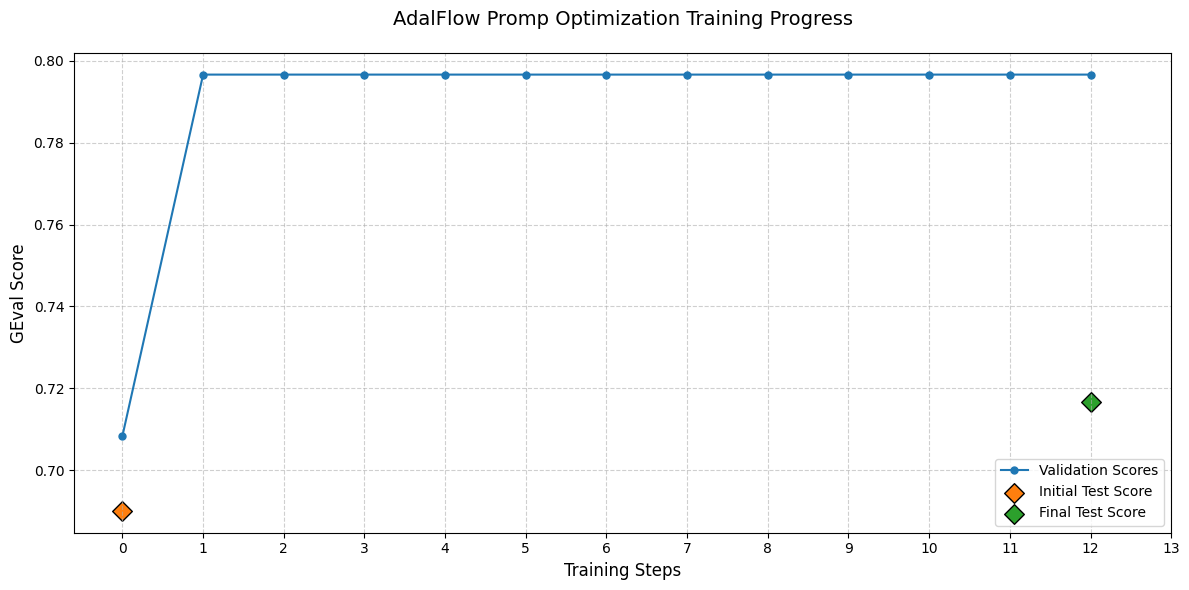

In [12]:
file = 'C:\\Users\\wuhan\\AppData\\Roaming\\adalflow\\ckpt\\HotPotQAAdal\\constrained_max_steps_12_b70f9_run_1.json'
plot_training_single(file)

### Understand the JSON Output

In [13]:
with open(file) as f:
    data = json.load(f)
print(data.keys())

dict_keys(['steps', 'val_scores', 'test_scores', 'step_results', 'effective_measure', 'validate_stats', 'time_stamp', 'total_time', 'test_score', 'trainer_state'])


In [14]:
print(data['test_score'])

best_idx = data['val_scores'].index(max(data['val_scores']))
print(best_idx)

best_prompt = data['step_results'][best_idx]['prompt'][0]['data']
print(best_prompt)

0.7166666666666667
1
Have the cheque reissued to the proper payee, such as the business name, and then deposit it into your business account.


In [15]:
for step in data['step_results']:
    for k, v in step.items():
        if k == 'prompt':
            print(len(v), f"prompt: {v[0]['data']}")
        else:
            print(f"{k}: {v}")
    print()

step: 0
val_score: 0.7083333333333333
test_score: 0.6900000000000001
attempted_val_score: None
1 prompt: Answer questions with short factoid answers.
                    You will receive context(contain relevant facts).
                    Think step by step.
                

step: 1
val_score: 0.7966666666666666
test_score: None
attempted_val_score: None
1 prompt: Have the cheque reissued to the proper payee, such as the business name, and then deposit it into your business account.

step: 2
val_score: 0.7966666666666666
test_score: None
attempted_val_score: 0.7816666666666666
1 prompt: Have the cheque reissued to the proper payee, such as the business name, and then deposit it into your business account.

step: 3
val_score: 0.7966666666666666
test_score: None
attempted_val_score: 0.65
1 prompt: Have the cheque reissued to the proper payee, such as the business name, and then deposit it into your business account.

step: 4
val_score: 0.7966666666666666
test_score: None
attempted_val_